In [187]:
# These have to be installed through running "pip install -r requirements.txt"

import re # for regular expressions
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import sklearn  # machine learning library
import nltk # natural language toolkit

from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize
from nltk.stem import WordNetLemmatizer # to lemmatize
from nltk.sentiment.vader import SentimentIntensityAnalyzer # to analyze sentiment

from wordcloud import WordCloud # to visualize text
from PIL import Image # import image

from gensim.test.utils import common_texts  # some example texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument  # doc2vec model

from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numbers 
from sklearn.ensemble import RandomForestClassifier # to build a model
from sklearn.linear_model import LogisticRegression # to build a model
from sklearn.model_selection import train_test_split # to split the data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix  # to evaluate the model
from sklearn.metrics import classification_report # to evaluate the model

In [218]:
# Storing the csv file as a pandas dataframe and sample 50/50 of the positive and negative scores
df = pd.read_csv('Hotel_Reviews.csv')

positive_reviews = df[df['Reviewer_Score'] > 5]
negative_reviews = df[df['Reviewer_Score'] < 5]

negative_sample = negative_reviews.sample(n=5000, random_state=42)
positive_sample = positive_reviews.sample(n=5000, random_state=42)

balanced_df = pd.concat([positive_sample, negative_sample])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(balanced_df['Reviewer_Score'].apply(lambda x: 'positive' if x > 5 else 'negative').value_counts())

Reviewer_Score
positive    5000
negative    5000
Name: count, dtype: int64


In [219]:
def replace(cell):
    if cell == "No Positive" or cell == "No Negative":
        return ""
    return cell



df['Negative_Review'] = df['Negative_Review'].apply(replace)
df['Positive_Review'] = df["Positive_Review"].apply(replace)

In [220]:

def combine_names(row):
    return f"{row['Positive_Review']} {row['Negative_Review']}"


df["Review"] = df.apply(combine_names, axis="columns")

In [221]:
df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Tags", "days_since_review", "lat", "lng", "Hotel_Name", "Total_Number_of_Reviews", "Negative_Review", "Positive_Review"], axis = "columns")
df

,Reviewer_Score,Review
0,2.9,close to Est Station and metro dirtesttttttt...
1,9.2,Very friendly staff and fantastic location Re...
2,8.3,Excellent breakfast buffet very handy for tra...
3,7.9,Very nice beds and room setting and excellent...
4,10.0,No
...,...,...
9995,4.2,A soundproofing in rooms is terrible You wil...
9996,2.9,The location is very good and is only a five ...
9997,3.3,location smell of foist in annexe coridors w...
9998,9.2,Very fast wifi Location is great No slipper...


In [222]:

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Apply the preprocessing function to your DataFrame
df['Review'] = df['Review'].apply(preprocess_text)

In [223]:
# Sentiment analysis

analyzer = SentimentIntensityAnalyzer()

# Returns a 1 if analyzers recognizes it as positive and 0 if not
def sentiment(text):
    result = analyzer.polarity_scores(text)
    sentiment = 1 if result["pos"] > 0 else 0
    return sentiment

#This function will return a more detailed sentiment analyze with float numbers
def sentiment_detailed(text):
    result = analyzer.polarity_scores(text)
    return result

df["Sentiment"] = df['Review'].apply(sentiment)
df["Sentiments"] = df["Review"].apply(sentiment_detailed)
df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)

df

#https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

,Reviewer_Score,Review,Sentiment,neg,neu,pos,compound
0,2.9,close est station metro dirtestttttttttttttt h...,1,0.000,0.887,0.113,0.3182
1,9.2,friendly staff fantastic location restaurant b...,1,0.000,0.779,0.221,0.7783
2,8.3,excellent breakfast buffet handy tram 27 city ...,1,0.000,0.682,0.318,0.7906
3,7.9,nice bed room setting excellent staff pricy,1,0.000,0.435,0.565,0.7579
4,10.0,,0,0.000,0.000,0.000,0.0000
...,...,...,...,...,...,...,...
9995,4.2,soundproofing room terrible wonderful opportun...,1,0.061,0.709,0.230,0.8225
9996,2.9,location good five minute walk paddimgton stat...,1,0.107,0.753,0.140,0.3262
9997,3.3,location smell foist annexe coridors member st...,1,0.107,0.754,0.139,0.2732
9998,9.2,fast wifi location great slipper room,1,0.000,0.549,0.451,0.6249


In [224]:
# Create TaggedDocument objects
docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(df['Review'])]

# Train the Doc2Vec model
model = Doc2Vec(docs, vector_size=5, window=2, min_count=1, workers=4)

# Infer vectors for each document
doc2vec_vectors = df['Review'].apply(lambda x: model.infer_vector(x.split(' ')))

# Convert the list of vectors into a DataFrame
doc2vec_df = pd.DataFrame(doc2vec_vectors.tolist())

# Add column names
doc2vec_df.columns = ['doc2vec_vector_' + str(i) for i in range(doc2vec_df.shape[1])]

# Concatenate with the original DataFrame
df = pd.concat([df, doc2vec_df], axis=1)

# Display the final DataFrame
df

,Reviewer_Score,Review,Sentiment,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,2.9,close est station metro dirtestttttttttttttt h...,1,0.000,0.887,0.113,0.3182,-0.150038,0.037638,0.439417,-0.233310,-0.092384
1,9.2,friendly staff fantastic location restaurant b...,1,0.000,0.779,0.221,0.7783,0.177705,0.096265,0.306411,-0.271188,-0.024919
2,8.3,excellent breakfast buffet handy tram 27 city ...,1,0.000,0.682,0.318,0.7906,0.299408,0.211381,0.031223,0.143577,-0.169956
3,7.9,nice bed room setting excellent staff pricy,1,0.000,0.435,0.565,0.7579,0.153585,0.070790,-0.005921,0.042532,-0.080277
4,10.0,,0,0.000,0.000,0.000,0.0000,0.117169,0.079014,0.197293,-0.014292,0.035693
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.2,soundproofing room terrible wonderful opportun...,1,0.061,0.709,0.230,0.8225,0.344060,-0.133129,0.300110,-0.393103,0.336884
9996,2.9,location good five minute walk paddimgton stat...,1,0.107,0.753,0.140,0.3262,0.127755,0.392097,0.448328,-0.015253,-0.355927
9997,3.3,location smell foist annexe coridors member st...,1,0.107,0.754,0.139,0.2732,0.432939,-0.063325,0.647105,-0.563423,0.117513
9998,9.2,fast wifi location great slipper room,1,0.000,0.549,0.451,0.6249,0.060023,-0.030289,0.062469,-0.016320,-0.146257


In [225]:
# Adding TF-IDF values to find out the importance of words in the reviews
tfidf = TfidfVectorizer(min_df = 10) # Initialize the TfidfVectorizer with a minimum document frequency of 10
tfidf_result = tfidf.fit_transform(df['Review']).toarray() # Fit and transform the 'Review' column to compute TF-IDF values
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())# Convert the TF-IDF matrix into a DataFrame
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns] # Rename columns to avoid conflicts with existing column names
tfidf_df.index = df.index # Align the index of the TF-IDF DataFrame with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1) # Concatenate the original DataFrame with the TF-IDF DataFrame
df.head()

,Reviewer_Score,Review,Sentiment,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,...,word_writing,word_written,word_wrong,word_yard,word_year,word_yellow,word_yes,word_yet,word_young,word_zero
0,2.9,close est station metro dirtestttttttttttttt h...,1,0.0,0.887,0.113,0.3182,-0.150038,0.037638,0.439417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.2,friendly staff fantastic location restaurant b...,1,0.0,0.779,0.221,0.7783,0.177705,0.096265,0.306411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.3,excellent breakfast buffet handy tram 27 city ...,1,0.0,0.682,0.318,0.7906,0.299408,0.211381,0.031223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.9,nice bed room setting excellent staff pricy,1,0.0,0.435,0.565,0.7579,0.153585,0.070790,-0.005921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.0,,0,0.0,0.000,0.000,0.0000,0.117169,0.079014,0.197293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
# Add a column for y, which gives the review either positive or negative
df['posneg'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 5 else 1)

In [227]:
# Calculate Positive and Negative Reviews
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Review']

In [228]:
# Generate WordCloud function for negative and positive reviews
# source: https://medium.com/@amalia.wulandiari/sentiment-analysis-hotel-review-python-nltk-846738de727f

def wordCloud_generator(data, color, color_map):

    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (7, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

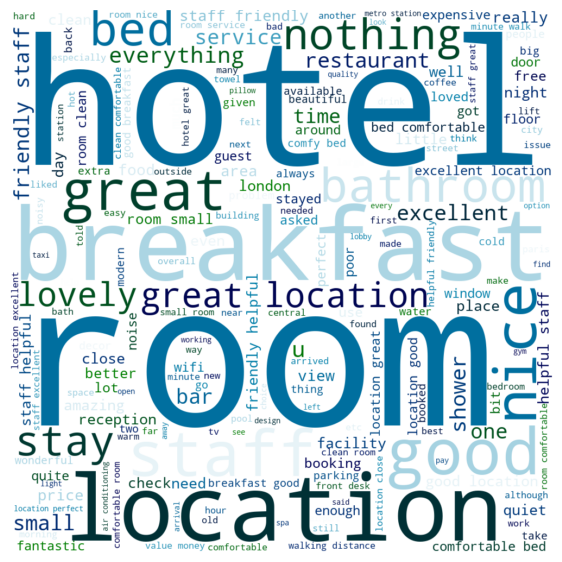

In [229]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

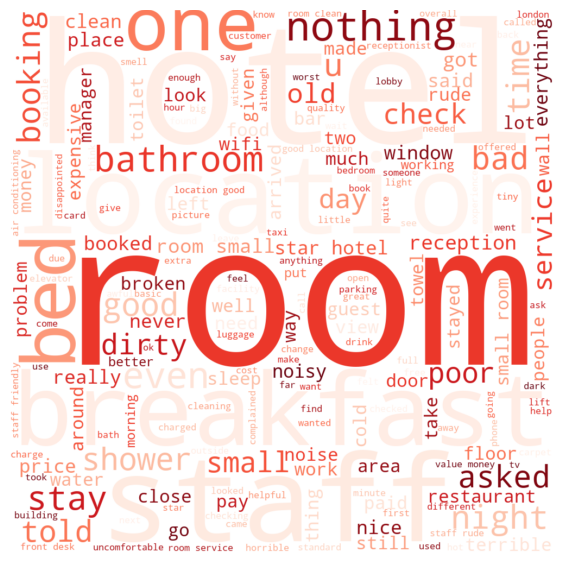

In [230]:
# WordCloud for Positive Review

wordCloud_generator(train_neg, 'white', 'Reds')

In [231]:
# Remove review before using the models
df = df.drop(['Review'], axis=1)

In [236]:
x = df.drop(['posneg', 'Reviewer_Score'], axis=1)
y = df['posneg']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [237]:
rfmodel = RandomForestClassifier(random_state=42)
rfmodel.fit(X_train, y_train)
prediction = rfmodel.predict(X_test)

classification_decision1 = (classification_report(y_test, rfmodel.predict(X_test)))

print(classification_decision1)


              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1228
           1       0.84      0.81      0.82      1272

    accuracy                           0.82      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.82      0.82      0.82      2500

